Make sure you have installed the necessary libraries:

In [1]:
!pip install torch-geometric pandas seaborn matplotlib rdkit dgl


Step 2: Load the QM9 Dataset

In [2]:
import torch
from torch_geometric.datasets import QM9

# Load the QM9 dataset
dataset = QM9(root='./data/QM9')

# Print basic information about the dataset
print(f"Dataset size: {len(dataset)}")
print(f"Number of features (atoms): {dataset.num_features}")
print(f"Number of labels (properties): {dataset.num_classes}")


Dataset size: 130831
Number of features (atoms): 11
Number of labels (properties): 19


Step 3: Basic EDA
3.1 Viewing Sample Molecule Data

In [3]:
# Inspect the first sample in the dataset
sample = dataset[0]
print(sample)

# Visualize the atomic features and edge indices (bonds)
print("Atomic features (x):", sample.x)
print("Edge indices (bonds):", sample.edge_index)
print("Molecular properties (y):", sample.y)


Data(x=[5, 11], edge_index=[2, 8], edge_attr=[8, 4], y=[1, 19], pos=[5, 3], z=[5], smiles='[H]C([H])([H])[H]', name='gdb_1', idx=[1])
Atomic features (x): tensor([[0., 1., 0., 0., 0., 6., 0., 0., 0., 0., 4.],
        [1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]])
Edge indices (bonds): tensor([[0, 0, 0, 0, 1, 2, 3, 4],
        [1, 2, 3, 4, 0, 0, 0, 0]])
Molecular properties (y): tensor([[    0.0000,    13.2100,   -10.5499,     3.1865,    13.7363,    35.3641,
             1.2177, -1101.4878, -1101.4098, -1101.3840, -1102.0229,     6.4690,
           -17.1722,   -17.2868,   -17.3897,   -16.1519,   157.7118,   157.7100,
           157.7070]])


3.2 Distribution of Atom Types

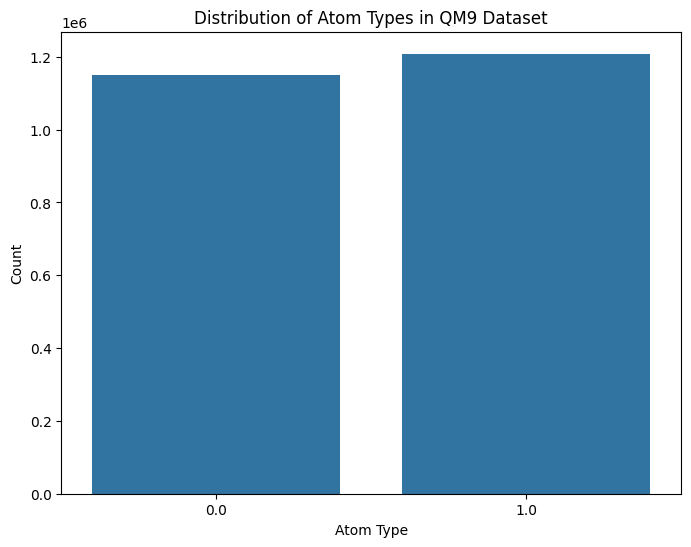

In [4]:
import pandas as pd
from collections import Counter

# Extract atom types from the dataset
atom_types = []
for data in dataset:
    atom_types.extend(data.x[:, 0].tolist())  # Assuming atom type is in the first column

# Count occurrences of each atom type
atom_counts = Counter(atom_types)
atom_df = pd.DataFrame(atom_counts.items(), columns=['Atom Type', 'Count'])

# Plot the atom type distribution
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.barplot(x="Atom Type", y="Count", data=atom_df)
plt.title("Distribution of Atom Types in QM9 Dataset")
plt.show()


3.3 Distribution of Molecular Properties

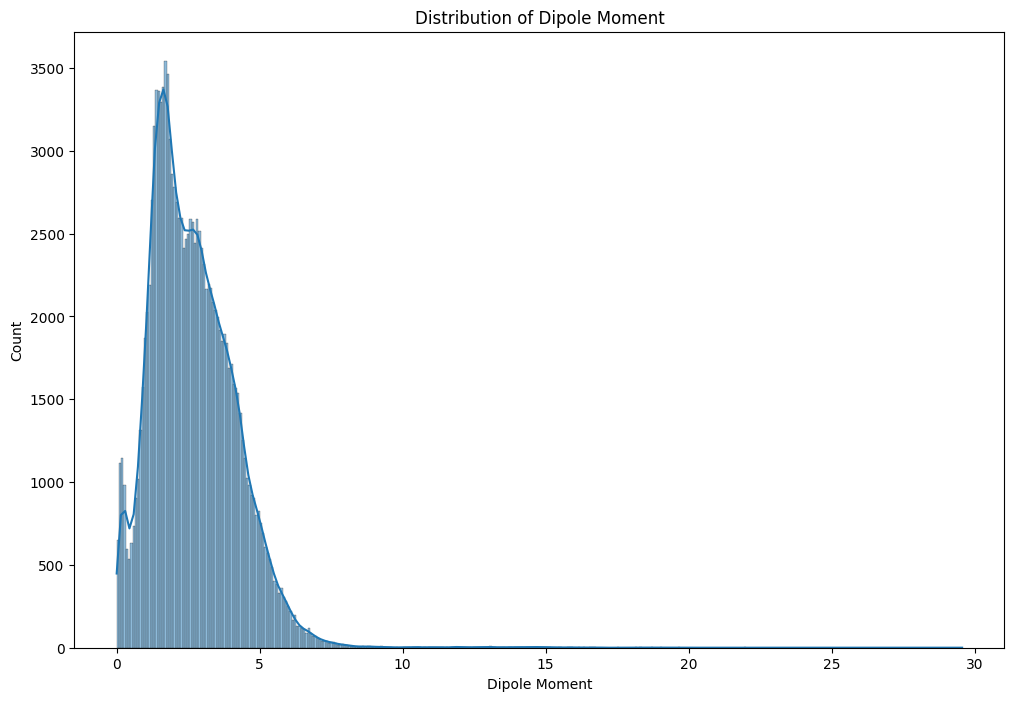

In [7]:
# Extract molecular properties (labels)
properties = torch.cat([data.y for data in dataset], dim=0)

# Convert to pandas DataFrame for easier handling
properties_df = pd.DataFrame(properties.numpy(), columns=[
    "Dipole Moment", "Isotropic Polarizability", "HOMO", "LUMO", "Gap",
    "Electronic Spatial Extent", "Zero Point Energy", "Internal Energy at 0K",
    "Internal Energy at 298K", "Enthalpy at 298K", "Free Energy at 298K", "Heat Capacity at 298K",
    "Property 13", "Property 14", "Property 15", "Property 16", "Property 17", "Property 18", "Property 19"
])

# Plot the distribution of the Dipole Moment
plt.figure(figsize=(12, 8))
sns.histplot(properties_df['Dipole Moment'], kde=True)
plt.title("Distribution of Dipole Moment")
plt.show()


Step 4: Advanced EDA
4.1 Molecular Weight Distribution

[18:20:03] Explicit valence for atom # 1 C, 5, is greater than permitted
[18:20:03] Explicit valence for atom # 1 C, 5, is greater than permitted
[18:20:03] Explicit valence for atom # 2 C, 5, is greater than permitted
[18:20:03] Explicit valence for atom # 2 C, 5, is greater than permitted
[18:20:03] Explicit valence for atom # 2 C, 5, is greater than permitted
[18:20:03] Explicit valence for atom # 2 C, 5, is greater than permitted
[18:20:03] Explicit valence for atom # 1 C, 5, is greater than permitted
[18:20:03] Explicit valence for atom # 2 C, 5, is greater than permitted
[18:20:03] Explicit valence for atom # 2 C, 5, is greater than permitted
[18:20:03] Explicit valence for atom # 1 C, 5, is greater than permitted
[18:20:03] Explicit valence for atom # 2 C, 5, is greater than permitted
[18:20:03] Explicit valence for atom # 2 C, 5, is greater than permitted
[18:20:03] Explicit valence for atom # 2 C, 5, is greater than permitted
[18:20:03] Explicit valence for atom # 3 C, 5, is g

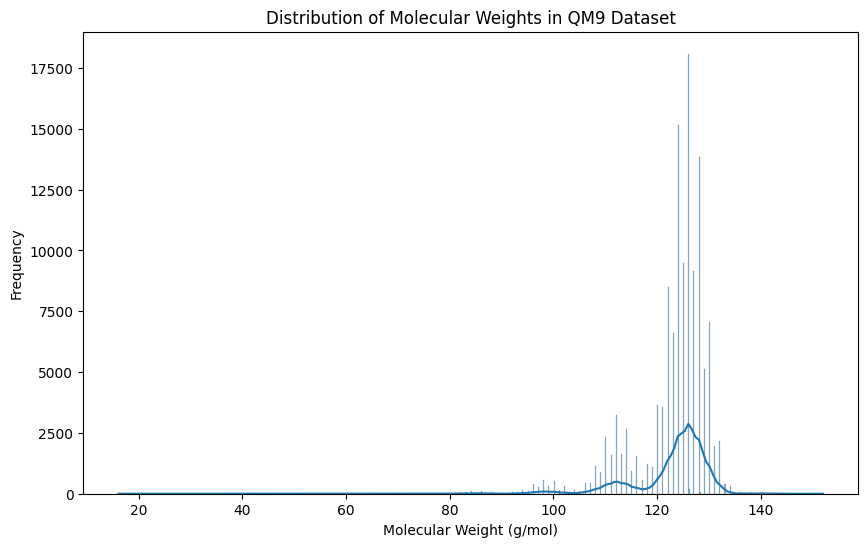

In [8]:
from rdkit.Chem import Descriptors
from rdkit import Chem

def compute_molecular_weights(dataset):
    molecular_weights = []
    for data in dataset:
        mol = Chem.MolFromSmiles(data.smiles)
        if mol:
            molecular_weights.append(Descriptors.MolWt(mol))
    return molecular_weights

# Compute molecular weights for the dataset
molecular_weights = compute_molecular_weights(dataset)

# Plot the molecular weight distribution
plt.figure(figsize=(10, 6))
sns.histplot(molecular_weights, kde=True)
plt.title("Distribution of Molecular Weights in QM9 Dataset")
plt.xlabel("Molecular Weight (g/mol)")
plt.ylabel("Frequency")
plt.show()


4.2 Bond Length Distribution

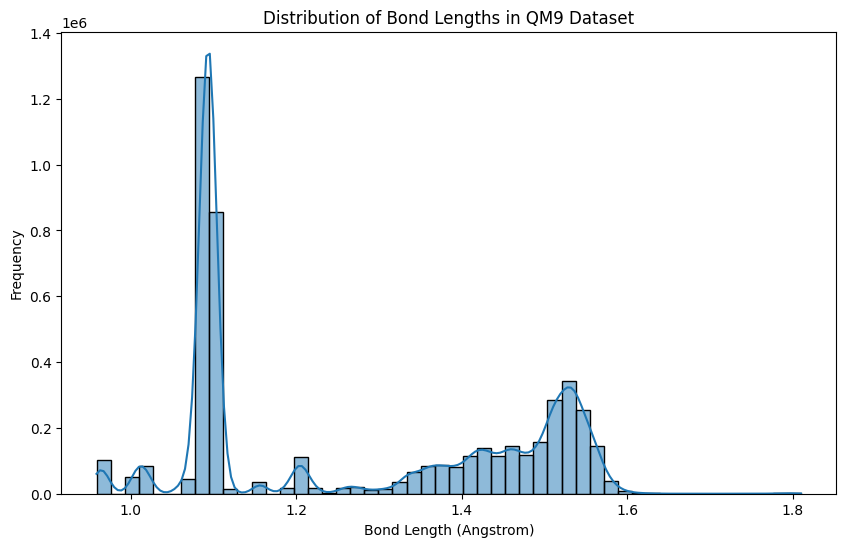

In [9]:
import numpy as np

def compute_bond_lengths(molecule):
    pos = molecule.pos  # 3D positions of atoms
    edge_index = molecule.edge_index  # Bonds (edges)

    bond_lengths = []
    for i, j in zip(edge_index[0], edge_index[1]):
        bond_length = torch.norm(pos[i] - pos[j]).item()
        bond_lengths.append(bond_length)

    return bond_lengths

# Calculate bond lengths for the entire dataset
all_bond_lengths = []
for data in dataset:
    bond_lengths = compute_bond_lengths(data)
    all_bond_lengths.extend(bond_lengths)

# Plot the bond length distribution
plt.figure(figsize=(10, 6))
sns.histplot(all_bond_lengths, bins=50, kde=True)
plt.title("Distribution of Bond Lengths in QM9 Dataset")
plt.xlabel("Bond Length (Angstrom)")
plt.ylabel("Frequency")
plt.show()


Step 5: Scatter Plots for Molecule Size vs Properties
5.1 Number of Atoms vs Dipole Moment

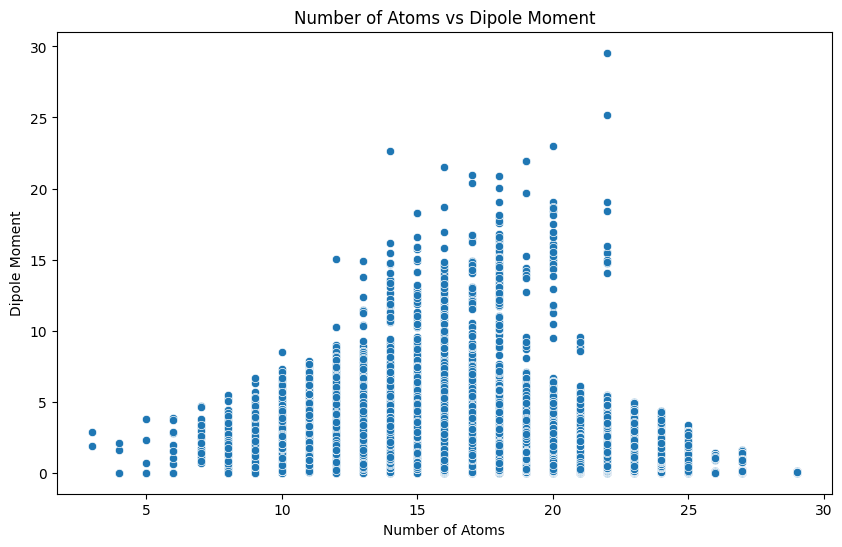

In [10]:
# Compute the number of atoms per molecule
num_atoms = [data.x.size(0) for data in dataset]

# Scatter plot between number of atoms and dipole moment
plt.figure(figsize=(10, 6))
sns.scatterplot(x=num_atoms, y=properties_df['Dipole Moment'])
plt.title("Number of Atoms vs Dipole Moment")
plt.xlabel("Number of Atoms")
plt.ylabel("Dipole Moment")
plt.show()


Step 6: Check for Missing Values
6.1 Checking Missing Values in Atomic Features

In [11]:
def check_missing_in_atomic_features(dataset):
    for i, data in enumerate(dataset):
        if torch.isnan(data.x).any():
            print(f"Missing values found in atomic features of molecule {i}")
        else:
            print(f"No missing values in atomic features of molecule {i}")

# Check for missing values in atomic features
check_missing_in_atomic_features(dataset)


Streaming output truncated to the last 5000 lines.
No missing values in atomic features of molecule 125831
No missing values in atomic features of molecule 125832
No missing values in atomic features of molecule 125833
No missing values in atomic features of molecule 125834
No missing values in atomic features of molecule 125835
No missing values in atomic features of molecule 125836
No missing values in atomic features of molecule 125837
No missing values in atomic features of molecule 125838
No missing values in atomic features of molecule 125839
No missing values in atomic features of molecule 125840
No missing values in atomic features of molecule 125841
No missing values in atomic features of molecule 125842
No missing values in atomic features of molecule 125843
No missing values in atomic features of molecule 125844
No missing values in atomic features of molecule 125845
No missing values in atomic features of molecule 125846
No missing values in atomic features of molecule 1258

6.2 Checking Missing Values in Molecular Properties


In [12]:
def check_missing_in_molecular_properties(dataset):
    missing_values = []
    for i, data in enumerate(dataset):
        if torch.isnan(data.y).any():
            missing_values.append(i)

    if missing_values:
        print(f"Missing values found in molecular properties for molecules: {missing_values}")
    else:
        print("No missing values in molecular properties.")

# Check for missing values in molecular properties
check_missing_in_molecular_properties(dataset)


No missing values in molecular properties.


6.3 Checking Missing or Invalid Edge Indices (Bonds)

In [13]:
def check_missing_in_edge_indices(dataset):
    invalid_edges = []
    for i, data in enumerate(dataset):
        if (data.edge_index < 0).any() or (data.edge_index >= data.x.size(0)).any():
            invalid_edges.append(i)

    if invalid_edges:
        print(f"Invalid edge indices found for molecules: {invalid_edges}")
    else:
        print("No invalid edge indices found.")

# Check for missing or invalid edge indices
check_missing_in_edge_indices(dataset)


No invalid edge indices found.


Step 7: Summary Check for Missing Values

In [14]:
def check_missing_values_in_dataset(dataset):
    print("Checking for missing values in the dataset...\n")

    # Check atomic features
    print("Atomic Features:")
    check_missing_in_atomic_features(dataset)

    # Check molecular properties
    print("\nMolecular Properties:")
    check_missing_in_molecular_properties(dataset)

    # Check edge indices (bonds)
    print("\nEdge Indices (Bonds):")
    check_missing_in_edge_indices(dataset)

# Run the summary check for missing values in the dataset
check_missing_values_in_dataset(dataset)


Streaming output truncated to the last 5000 lines.
No missing values in atomic features of molecule 125837
No missing values in atomic features of molecule 125838
No missing values in atomic features of molecule 125839
No missing values in atomic features of molecule 125840
No missing values in atomic features of molecule 125841
No missing values in atomic features of molecule 125842
No missing values in atomic features of molecule 125843
No missing values in atomic features of molecule 125844
No missing values in atomic features of molecule 125845
No missing values in atomic features of molecule 125846
No missing values in atomic features of molecule 125847
No missing values in atomic features of molecule 125848
No missing values in atomic features of molecule 125849
No missing values in atomic features of molecule 125850
No missing values in atomic features of molecule 125851
No missing values in atomic features of molecule 125852
No missing values in atomic features of molecule 1258

1. Principal Component Analysis (PCA)
We will apply PCA to the molecular properties to reduce the dimensionality of the data and explore the variance captured by the principal components.

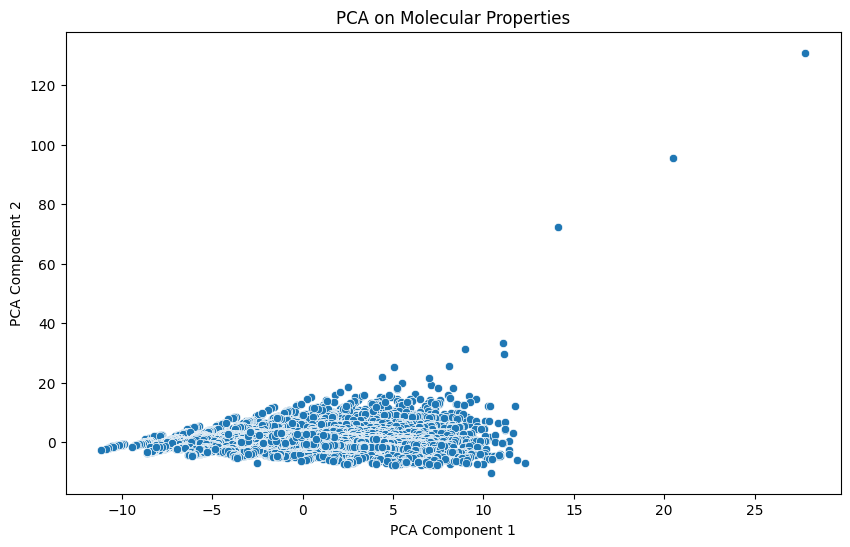

Explained variance by PCA components: [0.40981177 0.2199469 ]


In [15]:
from sklearn.decomposition import PCA
import numpy as np

# Normalize the molecular properties for PCA
properties_normalized = (properties_df - properties_df.mean()) / properties_df.std()

# Apply PCA to reduce dimensionality to 2 components
pca = PCA(n_components=2)
pca_result = pca.fit_transform(properties_normalized)

# Visualize the PCA result
plt.figure(figsize=(10, 6))
sns.scatterplot(x=pca_result[:, 0], y=pca_result[:, 1])
plt.title("PCA on Molecular Properties")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.show()

# Explained variance by the components
print("Explained variance by PCA components:", pca.explained_variance_ratio_)


2. t-SNE for Non-Linear Dimensionality Reduction
t-SNE is particularly useful for visualizing high-dimensional data in a lower-dimensional space by capturing non-linear relationships.

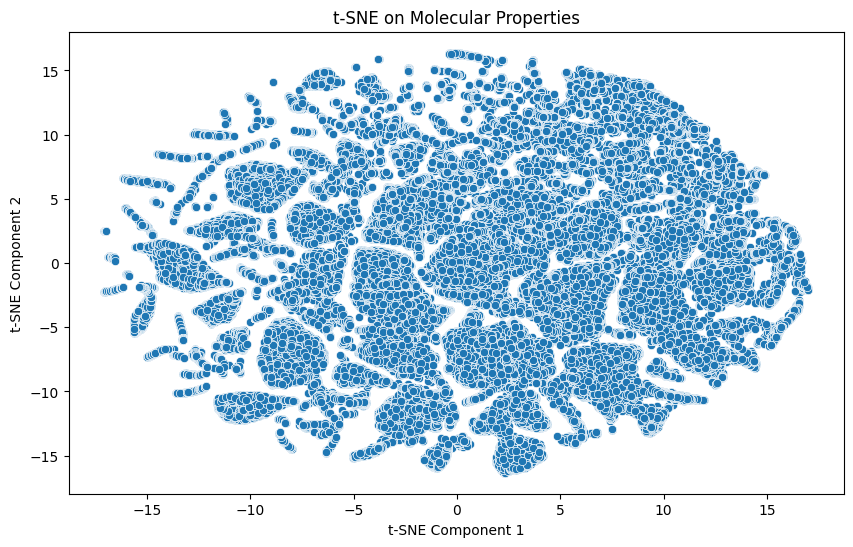

In [16]:
from sklearn.manifold import TSNE

# Apply t-SNE to the normalized molecular properties
tsne = TSNE(n_components=2, perplexity=30, n_iter=300)
tsne_result = tsne.fit_transform(properties_normalized)

# Visualize the t-SNE result
plt.figure(figsize=(10, 6))
sns.scatterplot(x=tsne_result[:, 0], y=tsne_result[:, 1])
plt.title("t-SNE on Molecular Properties")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.show()


3. Feature Engineering
3.1 Average Bond Length per Molecule
We’ll calculate the average bond length per molecule, which could be an important feature for further analysis or predictive modeling.

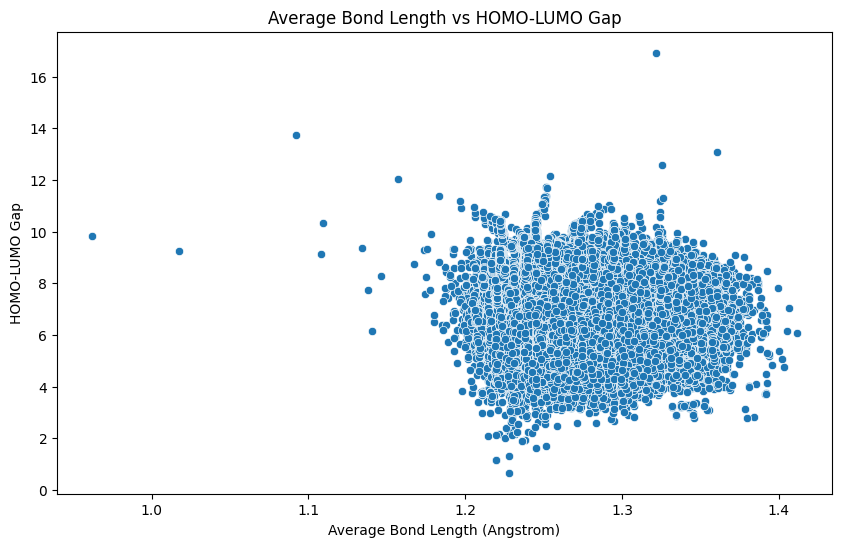

In [17]:
def compute_average_bond_length(dataset):
    avg_bond_lengths = []
    for data in dataset:
        bond_lengths = compute_bond_lengths(data)
        avg_bond_lengths.append(np.mean(bond_lengths) if bond_lengths else 0)
    return avg_bond_lengths

# Compute average bond lengths for the dataset
avg_bond_lengths = compute_average_bond_length(dataset)

# Add it to the properties DataFrame for further analysis
properties_df['Average Bond Length'] = avg_bond_lengths

# Scatter plot between average bond length and HOMO-LUMO Gap
plt.figure(figsize=(10, 6))
sns.scatterplot(x=properties_df['Average Bond Length'], y=properties_df['Gap'])
plt.title("Average Bond Length vs HOMO-LUMO Gap")
plt.xlabel("Average Bond Length (Angstrom)")
plt.ylabel("HOMO-LUMO Gap")
plt.show()


4. Molecular Fingerprinting
Molecular fingerprints are a way of encoding molecular structure into a binary vector. RDKit offers several types of molecular fingerprints such as Morgan (circular) fingerprints.

In [18]:
from rdkit.Chem import AllChem
from rdkit import DataStructs

def compute_fingerprints(dataset):
    fingerprints = []
    for data in dataset:
        mol = Chem.MolFromSmiles(data.smiles)
        if mol:
            fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=1024)
            fingerprints.append(fp)
    return fingerprints

# Compute molecular fingerprints for the dataset
fingerprints = compute_fingerprints(dataset)

# Convert fingerprints to NumPy arrays for analysis
fingerprint_array = np.array([np.array(fp) for fp in fingerprints])

# Compute pairwise similarity (Tanimoto similarity) for the first 10 molecules
similarity_matrix = np.zeros((10, 10))
for i in range(10):
    for j in range(10):
        similarity_matrix[i, j] = DataStructs.TanimotoSimilarity(fingerprints[i], fingerprints[j])

# Print the similarity matrix
print("Molecular Fingerprint Similarity (Tanimoto) for first 10 molecules:\n", similarity_matrix)


Streaming output truncated to the last 5000 lines.
[18:30:45] DEPRECATION WARNING: please use MorganGenerator
[18:30:45] DEPRECATION WARNING: please use MorganGenerator
[18:30:45] DEPRECATION WARNING: please use MorganGenerator
[18:30:45] DEPRECATION WARNING: please use MorganGenerator
[18:30:45] DEPRECATION WARNING: please use MorganGenerator
[18:30:45] DEPRECATION WARNING: please use MorganGenerator
[18:30:45] DEPRECATION WARNING: please use MorganGenerator
[18:30:45] DEPRECATION WARNING: please use MorganGenerator
[18:30:45] DEPRECATION WARNING: please use MorganGenerator
[18:30:45] DEPRECATION WARNING: please use MorganGenerator
[18:30:45] DEPRECATION WARNING: please use MorganGenerator
[18:30:45] DEPRECATION WARNING: please use MorganGenerator
[18:30:45] DEPRECATION WARNING: please use MorganGenerator
[18:30:45] DEPRECATION WARNING: please use MorganGenerator
[18:30:45] DEPRECATION WARNING: please use MorganGenerator
[18:30:45] DEPRECATION WARNING: please use MorganGenerator
[18:3

Molecular Fingerprint Similarity (Tanimoto) for first 10 molecules:
 [[1.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         1.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         1.         0.         0.         0.
  0.         0.         0.         0.16666667]
 [0.         0.         0.         1.         0.25       0.
  0.         0.         0.14285714 0.        ]
 [0.         0.         0.         0.25       1.         0.
  0.         0.         0.125      0.125     ]
 [0.         0.         0.         0.         0.         1.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  1.         0.25       0.14285714 0.14285714]
 [0.         0.         0.         0.         0.         0.
  0.25       1.         0.125      0.125     ]
 [0.         0.         0.         0.14285714 0.125      0.
  0.14285714 0.

 Correlation Analysis
Correlation analysis helps in understanding the linear relationships between molecular properties. We’ll use heatmaps and pair plots to visualize these relationships.

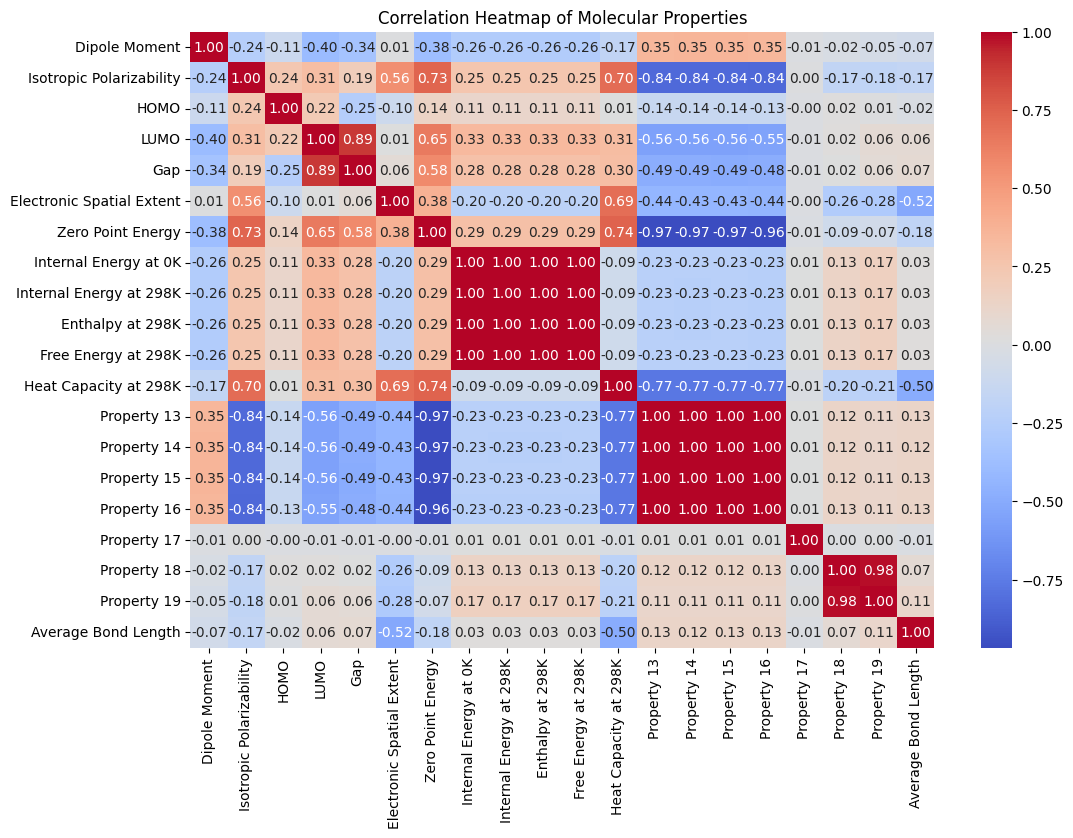

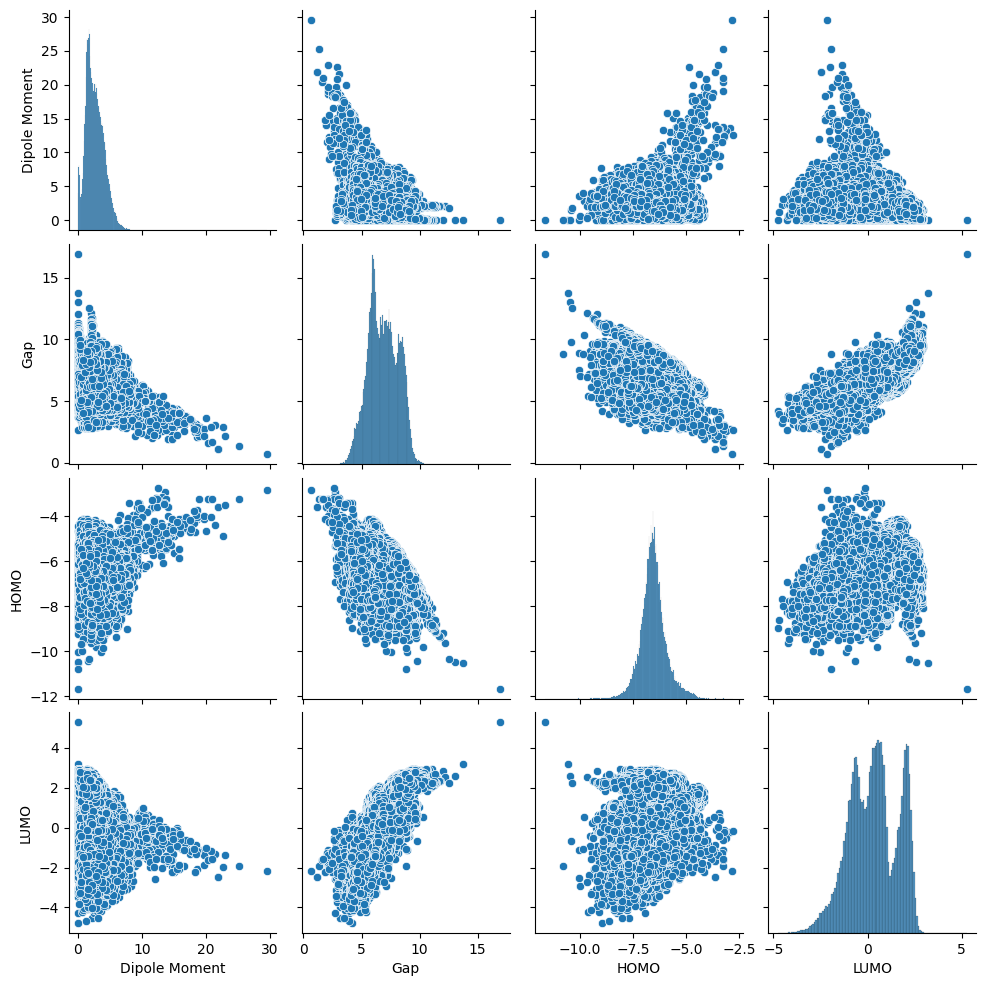

In [19]:
# Compute the correlation matrix
corr_matrix = properties_df.corr()

# Plot a heatmap of the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Heatmap of Molecular Properties")
plt.show()

# Pair plot for a subset of properties
sns.pairplot(properties_df[['Dipole Moment', 'Gap', 'HOMO', 'LUMO']])
plt.show()


6. Advanced Fragment and Scaffold Analysis
We can use scaffolds (core molecular structures) to analyze the diversity of the dataset in terms of molecular core structures.

[18:31:41] Explicit valence for atom # 1 C, 5, is greater than permitted
[18:31:41] Explicit valence for atom # 1 C, 5, is greater than permitted
[18:31:41] Explicit valence for atom # 2 C, 5, is greater than permitted
[18:31:41] Explicit valence for atom # 2 C, 5, is greater than permitted
[18:31:41] Explicit valence for atom # 2 C, 5, is greater than permitted
[18:31:41] Explicit valence for atom # 2 C, 5, is greater than permitted
[18:31:41] Explicit valence for atom # 1 C, 5, is greater than permitted
[18:31:41] Explicit valence for atom # 2 C, 5, is greater than permitted
[18:31:41] Explicit valence for atom # 2 C, 5, is greater than permitted
[18:31:41] Explicit valence for atom # 1 C, 5, is greater than permitted
[18:31:41] Explicit valence for atom # 2 C, 5, is greater than permitted
[18:31:41] Explicit valence for atom # 2 C, 5, is greater than permitted
[18:31:41] Explicit valence for atom # 2 C, 5, is greater than permitted
[18:31:41] Explicit valence for atom # 3 C, 5, is g

Number of unique scaffolds: 20694


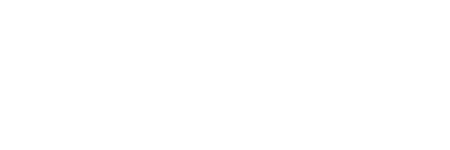

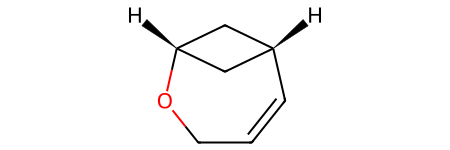

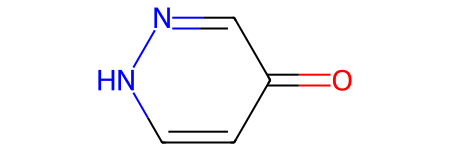

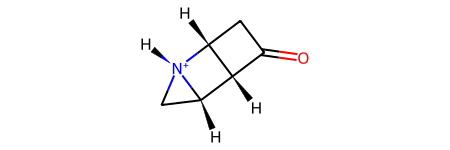

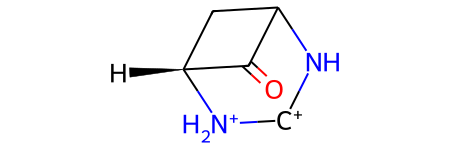

In [20]:
from rdkit.Chem.Scaffolds import MurckoScaffold

def compute_scaffolds(dataset):
    scaffolds = []
    for data in dataset:
        mol = Chem.MolFromSmiles(data.smiles)
        if mol:
            scaffold = MurckoScaffold.GetScaffoldForMol(mol)
            scaffolds.append(scaffold)
    return scaffolds

# Compute scaffolds for the dataset
scaffolds = compute_scaffolds(dataset)

# Count unique scaffolds
unique_scaffolds = set([Chem.MolToSmiles(scaffold) for scaffold in scaffolds])
print(f"Number of unique scaffolds: {len(unique_scaffolds)}")

# Visualize a few scaffolds
for scaffold in list(unique_scaffolds)[:5]:
    display(Chem.MolFromSmiles(scaffold))


7. Clustering Molecules Based on Properties
We can cluster molecules using K-Means or hierarchical clustering to identify groups of molecules with similar properties.

7.1 K-Means Clustering

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


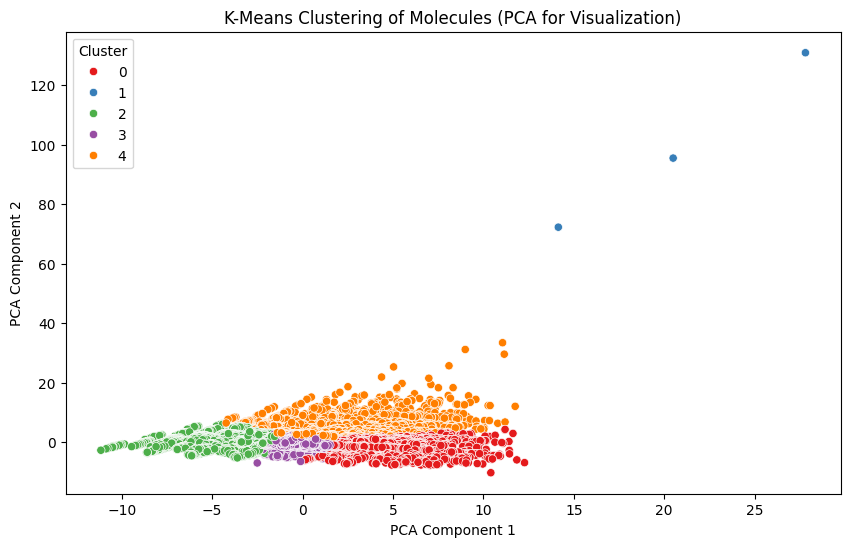

In [21]:
from sklearn.cluster import KMeans

# Apply K-Means clustering
kmeans = KMeans(n_clusters=5, random_state=0)
properties_df['Cluster'] = kmeans.fit_predict(properties_normalized)

# Visualize clusters using PCA
plt.figure(figsize=(10, 6))
sns.scatterplot(x=pca_result[:, 0], y=pca_result[:, 1], hue=properties_df['Cluster'], palette='Set1')
plt.title("K-Means Clustering of Molecules (PCA for Visualization)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.show()


1. Advanced Feature Engineering
1.1 Graph-Based Feature Engineering
Since molecules are naturally represented as graphs (atoms are nodes, bonds are edges), you can extract graph-based features such as:

Graph size: Number of atoms (nodes) and bonds (edges).
Graph density: How connected a molecule is relative to its size.
Node degree distribution: Measure how atoms are connected in the molecule.
Centrality measures: Eigenvector centrality, closeness, and betweenness to determine key atoms.

In [22]:
import networkx as nx

def extract_graph_features(dataset):
    graph_features = []
    for data in dataset:
        G = nx.Graph()
        edge_index = data.edge_index
        G.add_edges_from(edge_index.T.tolist())

        # Number of atoms (nodes) and bonds (edges)
        num_atoms = len(data.x)
        num_bonds = len(G.edges)

        # Graph density and other features
        density = nx.density(G)
        avg_degree = sum(dict(G.degree()).values()) / num_atoms
        centrality = nx.eigenvector_centrality_numpy(G)
        avg_centrality = sum(centrality.values()) / num_atoms

        graph_features.append([num_atoms, num_bonds, density, avg_degree, avg_centrality])

    return pd.DataFrame(graph_features, columns=["Num Atoms", "Num Bonds", "Density", "Avg Degree", "Avg Centrality"])

# Extract graph features and add to properties DataFrame
graph_features_df = extract_graph_features(dataset)
properties_df = pd.concat([properties_df, graph_features_df], axis=1)


2. Predictive Modeling (Supervised Learning)
You can build machine learning models to predict molecular properties like HOMO-LUMO gap, dipole moment, etc., using the features extracted earlier. Some possible models include:

Random Forests: Useful for feature importance analysis and predictions.
Gradient Boosting Machines (XGBoost, LightGBM): For highly predictive models with feature importance.
Graph Neural Networks (GNNs): Since molecules are naturally graphs, GNNs are highly effective.
2.1 Random Forest for Property Prediction

RMSE for HOMO-LUMO Gap prediction: 0.3948546511518369


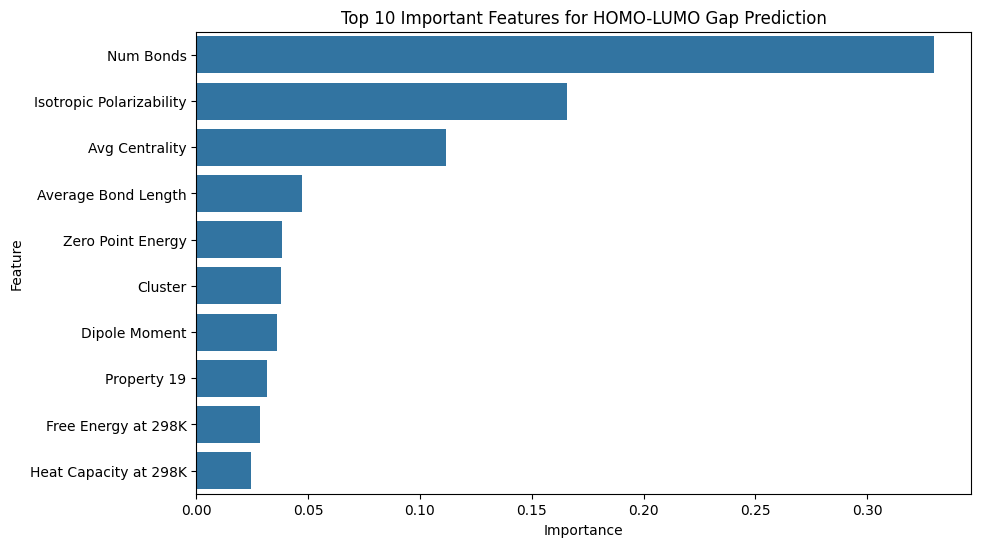

In [23]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Split data into train and test sets
X = properties_df.drop(columns=['HOMO', 'LUMO', 'Gap'])  # Features
y = properties_df['Gap']  # Target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit a random forest model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predict and evaluate
y_pred = model.predict(X_test)
rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f"RMSE for HOMO-LUMO Gap prediction: {rmse}")

# Feature importance
importances = model.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(10))
plt.title("Top 10 Important Features for HOMO-LUMO Gap Prediction")
plt.show()


2.2 Graph Neural Networks (GNN) for Property Prediction
You can implement a GNN model to predict properties directly from the molecular graph structure.

In [24]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class GNNModel(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GNNModel, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.fc = torch.nn.Linear(hidden_dim, output_dim)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        x = torch.mean(x, dim=0)  # Global pooling (mean)
        return self.fc(x)

# Train GNN model for HOMO-LUMO Gap prediction


3. Unsupervised Learning: Clustering with Structural Similarity
In addition to the earlier K-Means and Hierarchical Clustering, you can also cluster molecules based on their fingerprints or scaffolds to identify structural similarity.

3.1 Clustering Using Molecular Fingerprints
You can perform clustering directly on molecular fingerprints (bit vectors) using algorithms like DBSCAN, which can handle non-linear clustering patterns.

Streaming output truncated to the last 5000 lines.
[18:41:16] DEPRECATION WARNING: please use MorganGenerator
[18:41:16] DEPRECATION WARNING: please use MorganGenerator
[18:41:16] DEPRECATION WARNING: please use MorganGenerator
[18:41:16] DEPRECATION WARNING: please use MorganGenerator
[18:41:16] DEPRECATION WARNING: please use MorganGenerator
[18:41:16] DEPRECATION WARNING: please use MorganGenerator
[18:41:16] DEPRECATION WARNING: please use MorganGenerator
[18:41:16] DEPRECATION WARNING: please use MorganGenerator
[18:41:16] DEPRECATION WARNING: please use MorganGenerator
[18:41:16] DEPRECATION WARNING: please use MorganGenerator
[18:41:16] DEPRECATION WARNING: please use MorganGenerator
[18:41:16] DEPRECATION WARNING: please use MorganGenerator
[18:41:16] DEPRECATION WARNING: please use MorganGenerator
[18:41:16] DEPRECATION WARNING: please use MorganGenerator
[18:41:16] DEPRECATION WARNING: please use MorganGenerator
[18:41:16] DEPRECATION WARNING: please use MorganGenerator
[18:4

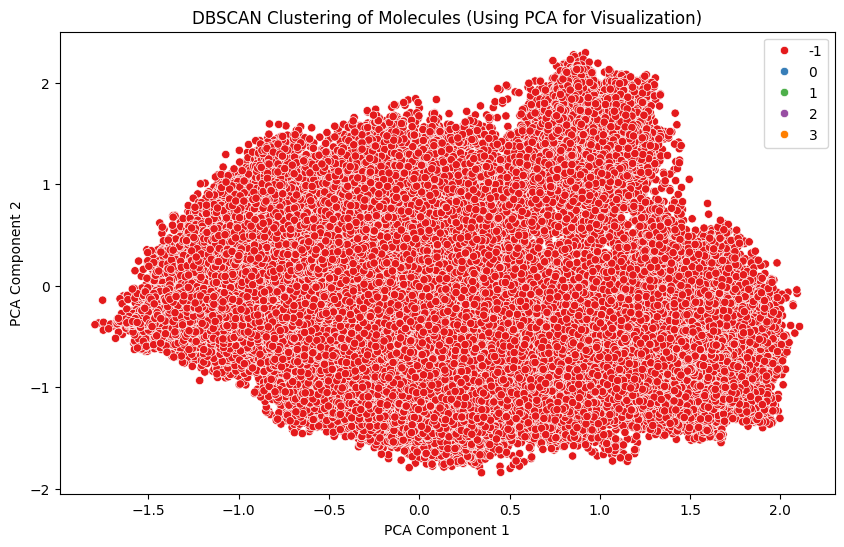

In [25]:
from sklearn.cluster import DBSCAN
from rdkit import DataStructs

# Compute molecular fingerprints (from earlier)
fingerprints = compute_fingerprints(dataset)

# Convert fingerprints to NumPy arrays for clustering
fingerprint_array = np.array([np.array(fp) for fp in fingerprints])

# Apply DBSCAN clustering
dbscan = DBSCAN(metric='euclidean')
clusters = dbscan.fit_predict(fingerprint_array)

# Visualize clusters using PCA
pca_result = PCA(n_components=2).fit_transform(fingerprint_array)
plt.figure(figsize=(10, 6))
sns.scatterplot(x=pca_result[:, 0], y=pca_result[:, 1], hue=clusters, palette='Set1')
plt.title("DBSCAN Clustering of Molecules (Using PCA for Visualization)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.show()


4. Advanced Fragment and Scaffold Analysis
4.1 Fragment Frequency Analysis
You can explore the most common fragments or building blocks that occur across the dataset. This is particularly useful for understanding drug-like molecules.

In [26]:
from collections import Counter
from rdkit.Chem import BRICS

def fragment_analysis(dataset):
    fragments = []
    for data in dataset:
        mol = Chem.MolFromSmiles(data.smiles)
        if mol:
            fragments.extend(BRICS.BRICSDecompose(mol))

    # Count the most frequent fragments
    fragment_counts = Counter(fragments)
    return fragment_counts

# Perform fragment analysis
fragment_counts = fragment_analysis(dataset)

# Display the top 10 most common fragments
print("Top 10 most common fragments:")
print(fragment_counts.most_common(10))


[18:49:23] Explicit valence for atom # 1 C, 5, is greater than permitted
[18:49:24] Explicit valence for atom # 1 C, 5, is greater than permitted
[18:49:24] Explicit valence for atom # 2 C, 5, is greater than permitted
[18:49:24] Explicit valence for atom # 2 C, 5, is greater than permitted
[18:49:24] Explicit valence for atom # 2 C, 5, is greater than permitted
[18:49:24] Explicit valence for atom # 2 C, 5, is greater than permitted
[18:49:24] Explicit valence for atom # 1 C, 5, is greater than permitted
[18:49:25] Explicit valence for atom # 2 C, 5, is greater than permitted
[18:49:25] Explicit valence for atom # 2 C, 5, is greater than permitted
[18:49:25] Explicit valence for atom # 1 C, 5, is greater than permitted
[18:49:25] Explicit valence for atom # 2 C, 5, is greater than permitted
[18:49:25] Explicit valence for atom # 2 C, 5, is greater than permitted
[18:49:25] Explicit valence for atom # 2 C, 5, is greater than permitted
[18:49:25] Explicit valence for atom # 3 C, 5, is g

Top 10 most common fragments:
[('[3*]OC', 8191), ('[8*]CO', 7097), ('[8*]CC', 6875), ('[3*]O[3*]', 4249), ('[4*]CC', 2638), ('[5*]NC', 2271), ('[4*]C[8*]', 2172), ('[15*]C1CC1', 2014), ('[5*]N[5*]', 1797), ('[13*][C@H]1CO1', 1650)]


[18:51:23] Explicit valence for atom # 8 C, 5, is greater than permitted
[18:51:24] Explicit valence for atom # 5 C, 5, is greater than permitted
[18:51:24] Explicit valence for atom # 5 C, 5, is greater than permitted
[18:51:24] Explicit valence for atom # 5 C, 5, is greater than permitted


5. Generative Models for Molecule Generation
You can implement Generative Adversarial Networks (GANs), Variational Autoencoders (VAEs), or Graph Generative Models to generate novel molecules. For example, a VAE model can be used to encode a molecule into a latent space and then decode it back to generate new molecules.

5.1 Variational Autoencoder (VAE) for Molecule Generation

In [27]:
class VAEModel(torch.nn.Module):
    def __init__(self, input_dim, latent_dim, output_dim):
        super(VAEModel, self).__init__()
        self.encoder = torch.nn.Linear(input_dim, latent_dim)
        self.decoder = torch.nn.Linear(latent_dim, output_dim)

    def forward(self, x):
        z = self.encoder(x)
        reconstructed_x = self.decoder(z)
        return reconstructed_x

# Train VAE model for molecule generation


6. Molecular Descriptor Calculation
In addition to molecular fingerprints, you can calculate a wide range of molecular descriptors using libraries like RDKit. These include:

LogP (lipophilicity): Measure of molecule's solubility.
Topological Polar Surface Area (TPSA): Used in drug-likeness predictions.
Number of Rotatable Bonds: Important for molecular flexibility.

In [28]:
from rdkit.Chem import Descriptors

def compute_descriptors(dataset):
    descriptors = []
    for data in dataset:
        mol = Chem.MolFromSmiles(data.smiles)
        if mol:
            logp = Descriptors.MolLogP(mol)
            tpsa = Descriptors.TPSA(mol)
            rotatable_bonds = Descriptors.NumRotatableBonds(mol)
            descriptors.append([logp, tpsa, rotatable_bonds])
    return pd.DataFrame(descriptors, columns=["LogP", "TPSA", "Rotatable Bonds"])

# Calculate molecular descriptors
descriptors_df = compute_descriptors(dataset)

# Add descriptors to properties_df for further analysis
properties_df = pd.concat([properties_df, descriptors_df], axis=1)


[18:51:24] Explicit valence for atom # 1 C, 5, is greater than permitted
[18:51:24] Explicit valence for atom # 1 C, 5, is greater than permitted
[18:51:24] Explicit valence for atom # 2 C, 5, is greater than permitted
[18:51:24] Explicit valence for atom # 2 C, 5, is greater than permitted
[18:51:24] Explicit valence for atom # 2 C, 5, is greater than permitted
[18:51:24] Explicit valence for atom # 2 C, 5, is greater than permitted
[18:51:24] Explicit valence for atom # 1 C, 5, is greater than permitted
[18:51:24] Explicit valence for atom # 2 C, 5, is greater than permitted
[18:51:24] Explicit valence for atom # 2 C, 5, is greater than permitted
[18:51:24] Explicit valence for atom # 1 C, 5, is greater than permitted
[18:51:24] Explicit valence for atom # 2 C, 5, is greater than permitted
[18:51:24] Explicit valence for atom # 2 C, 5, is greater than permitted
[18:51:24] Explicit valence for atom # 2 C, 5, is greater than permitted
[18:51:24] Explicit valence for atom # 3 C, 5, is g